In [1]:
# Step 1: Install Required Libraries
!pip install imbalanced-learn tensorflow --quiet


In [2]:
# Step 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")


In [10]:
# Load the CSV file
df = pd.read_csv('/content/creditcard.csv')  # update path if needed

# Standardize 'Amount' and drop 'Time'
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])
df.drop('Time', axis=1, inplace=True)

# Print class distribution
print(df['Class'].value_counts())  # 0 = normal, 1 = fraud


Class
0    284315
1       492
Name: count, dtype: int64


In [11]:
# Features and label
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [12]:
iso = IsolationForest(contamination=0.001)
iso.fit(X_train)

y_pred_iso = iso.predict(X_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

print("🛑 Isolation Forest Results")
print(confusion_matrix(y_test, y_pred_iso))
print(classification_report(y_test, y_pred_iso))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_iso))


🛑 Isolation Forest Results
[[56820    44]
 [   80    18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.29      0.18      0.23        98

    accuracy                           1.00     56962
   macro avg       0.64      0.59      0.61     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.5914498466803716


In [13]:
# ✅ FIX: Now X_train is defined

# Train only on non-fraud data
X_train_normal = X_train[y_train == 0]

# Autoencoder architecture
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

# Train autoencoder only on normal transactions
autoencoder.fit(X_train_normal, X_train_normal,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_split=0.1,
                verbose=1)


Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.8857 - val_loss: 0.4830
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4505 - val_loss: 0.3767
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3675 - val_loss: 0.3400
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3384 - val_loss: 0.3244
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3255 - val_loss: 0.3122
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3180 - val_loss: 0.3096
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3074 - val_loss: 0.3033
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3001 - val_loss: 0.2919
Epoch 9/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2990 - val_loss: 0.2872
Epoch 10/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2924 - val_loss: 0.2852


In [14]:
# Reconstruct and calculate MSE
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Threshold = 95th percentile of non-fraud MSE
threshold = np.percentile(mse[y_test == 0], 95)
y_pred_ae = [1 if e > threshold else 0 for e in mse]

print("🤖 Autoencoder Results")
print(confusion_matrix(y_test, y_pred_ae))
print(classification_report(y_test, y_pred_ae))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_ae))


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
🤖 Autoencoder Results
[[54020  2844]
 [   12    86]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.88      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.91      0.52     56962
weighted avg       1.00      0.95      0.97     56962

ROC AUC Score: 0.9137684758765633


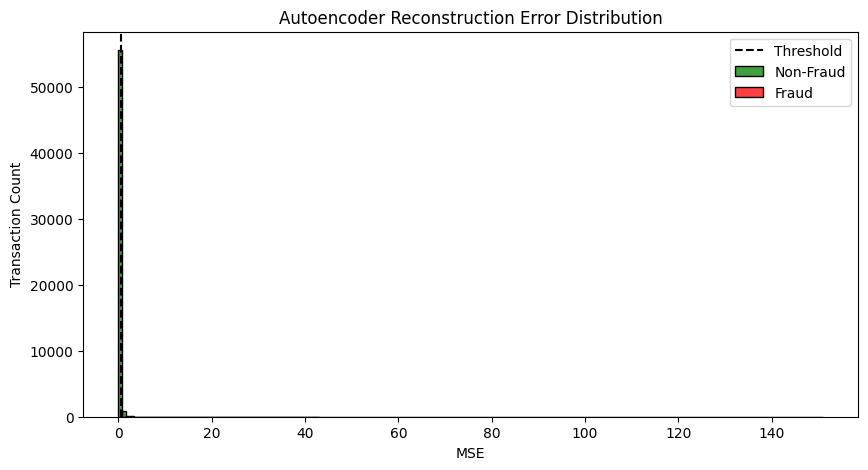

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(mse[y_test == 0], bins=50, color='green', label='Non-Fraud')
sns.histplot(mse[y_test == 1], bins=50, color='red', label='Fraud')
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.legend()
plt.title("Autoencoder Reconstruction Error Distribution")
plt.xlabel("MSE")
plt.ylabel("Transaction Count")
plt.show()
